In [1]:
import numpy as np
import astropy.io.fits as fits 
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from scipy.optimize import leastsq
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from muse import *

In [2]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
#hdu.info()
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavstart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavstart+np.arange(qso_data.shape[0])*wavint #. This is the same as the one below. 
[central_x,central_y]= [67,51]#

In [3]:
z =0.043143 
k = 1+z
select = (wave>4750*k)&(wave<5090*k)

In [4]:
mini_cube = qso_data[:,central_y - 4:central_y + 5,central_x - 4:central_x + 5][select]
mini_cube_error = qso_error[:,central_y - 4:central_y + 5,central_x - 4:central_x + 5][select]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 4)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 4)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
new_hdu.writeto('3arcsec_minicube.fits',overwrite=True)

In [5]:
#par = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32) #dtype = datatype. the type of the output array
#err = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
#fitted = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
#residuals = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [6]:
#for i in range(mini_data.shape[1]):
#    for j in range(mini_data.shape[2]):
        #y = mini_data[:,i,j][select]
        #y_err = mini_error[:,i,j][select]
        #x = wave[select]    

        #x0=[2,40,12942,50.0,5,5,12842,100.0,5,1,12942,1000.0,1,1,12942,1000.0,-0.001,0.1]
        #popt1,pcov1 = leastsq(full_gauss2,x0,args = (x,y,y_err),maxfev=10000000)
        #model = full_gauss2(popt1,x,y,y_err)*(y_err)+y
        
        #plt.plot(x,y,label='data')
        #plt.plot(x,model,label='fit')
        
        #fitted[:,i,j] = model
        #residuals = y - fitted[:,i,j]
        
        #plt.plot(x,residuals,label = 'residuals')
        #plt.legend()
        #plt.show()
        
        

In [7]:
shape = mini_cube.shape[1]*mini_cube.shape[2]
int_spectrum = sum(mini_cube[:,i,j] for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2]))
int_error = np.sqrt(sum((mini_cube_error[:,i,j])**2 for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2])))        

In [8]:
#To add erros, sqaure and add them both, and then square root them: propagation of uncertainty/errors. 

In [9]:
y = int_spectrum
y_err = int_error
x = wave[select]

x0=[40,500,12942,50,40,400,12942,50,80,100,12842,100,100,50,12942,1000,40,20,12942,1000,-0.001,100]
popt1,pcov1 = leastsq(full_gauss2,x0,args = (x,y,y_err),maxfev=10000000)
print (popt1)

[  4.99917231e+01   5.98278650e+02   1.28153676e+04   9.71273424e+01
   2.36753668e+01   2.84929053e+02   1.30104477e+04   7.70367913e+01
   2.37973869e+01   3.02412244e+02   1.28533822e+04   2.79347434e+02
   7.27684770e+01   9.38046481e+00   1.40134573e+04   1.60048976e+03
   6.16670102e+01   1.46637348e+01   1.14137605e+04   1.63339017e+03
  -5.96506743e+01   4.16584091e+02]


In [10]:
#We see Bipolar outflow from adding another nlr component. One is redshifted, the other is blueshifted. 

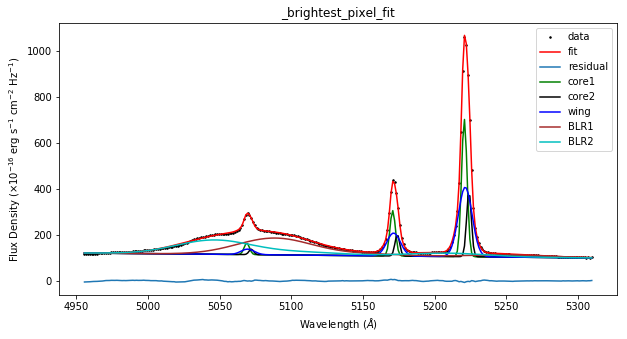

In [42]:
(amp_Hb_1,amp_OIII50071,vel_OIII1,vel_sigma_OIII1,amp_Hb_2,amp_OIII50072,vel_OIII2,vel_sigma_OIII2,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c)=popt1

fig = plt.figure(figsize=(10,5))
model = full_gauss2(popt1,x,y,y_err)*(y_err)+y
residual = y - model


plt.plot(x,y,'ko',markersize=1.5,label='data')
plt.plot(x,model,'r',label='fit')
plt.plot(x,residual,label='residual')

plt.plot(x,Hb_O3_gauss(x,amp_Hb_1,amp_OIII50071,vel_OIII1,vel_sigma_OIII1)+ continuum(x,m,c),'-g',label='core1')
plt.plot(x,Hb_O3_gauss(x,amp_Hb_2,amp_OIII50072,vel_OIII2,vel_sigma_OIII2)+ continuum(x,m,c),'-k',label='core2')
plt.plot(x,Hb_O3_gauss(x,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br)+ continuum(x,m,c),color ='blue',label='wing')
plt.plot(x,Hb_Fe_doublet_gauss(x,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1)+ continuum(x,m,c),color ='brown',label='BLR1')
plt.plot(x,Hb_Fe_doublet_gauss(x,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2)+ continuum(x,m,c),'-c',label='BLR2')

#plt.plot(x,Hb_Fe_doublet_gauss(x,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2) + continuum(x,m,c),'-c',label='BLR2')
plt.title('_brightest_pixel_fit')
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
plt.legend()
plt.show() 
        
#plt.legend()
plt.show()

In [ ]:
### print (vel_OIII1,vel_OIII2,vel_OIII_br)#Black is the core. We can see that it is outflowing. Beacuse velocity should be 12942, and the core is redshifted as it's velocity os 13010. 

In [33]:
vel_offset1 = vel_OIII2 - vel_OIII1
vel_offset2 = vel_OIII2 - vel_OIII_br

print(vel_offset1,vel_offset2)#they are coupled. This is more accurate than the 207km/s due to instrumental errors. 

195.080029757 157.065466299


In [36]:
sigma_eff_core1 = line_width_recons(vel_sigma_OIII1,rest_line=5006.8,inst_res_fwhm=0)
sigma_eff_wing = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0) 
    

In [37]:
flux_core1 = amp_OIII50071*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_core1))#instead of Hb1_blr, we use SII amp1,amp2. 
flux_wing = amp_OIII5007_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_wing)) 


In [40]:
print (flux_core1)
print(flux_wing)#The wing is coming from the very compact/dense region. 
#For next week, re-do the analysis with only 1 nlr core, 1nlr wing, and 1 blr component

2431.72557643
3537.34619841


In [39]:
3441/3537

0.9728583545377438

In [43]:
ratio = amp_Hb_br/amp_OIII5007_br
ratio

0.078691876150338472